##Imports

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import os
import glob
import shutil
import itertools
import random

from IPython.core.display import display, HTML
from matplotlib.image import imread, imsave
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, plot, iplot
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import svm, grid_search, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


##Mount google drive directory

In [35]:
from google.colab import files, drive, auth
import os

drive.mount("/content/gdrive", force_remount=False)

PATH = "/content/gdrive/My Drive/AED/"

if os.path.isfile(f"{PATH}data.zip"): #and not os.path.isdir("data/"):
    print("\nUnziping the data...")
    !unzip -q gdrive/My\ Drive/AED/data.zip
    print("Done.")
else:
    print("\nData directory already ready.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Data directory already ready.


##I.  Lecture des CSV

###Stratification du train

In [0]:
def split_train_test(X, y, feature_column_name):
    """
    df : df to split into train and test
    
    train : train dataframe
    test : test dataframe
    """    
    # get indexes
    index_violent = list(y.index[y[feature_column_name] == 1])
    index_non_violent = list(set(y.index) - set(index_violent))
    N = int(len(index_violent)*0.8)
    
    # set the random seed (to always return the same train and test samples)
    random.seed(1)
    
    # separate into train and test
    index_violent_train = random.sample(index_violent, N)
    index_violent_test = list(set(index_violent) - set(index_violent_train))

    index_non_violent_train = random.sample(index_non_violent, N)
    index_non_violent_test = list(set(index_non_violent) - set(index_non_violent))

    # concatenate
    index_train = index_violent_train + index_non_violent_train
    index_test = list(set(y.index) - set(index_train))

    y_train = y[y.index.isin(index_train)]
    y_test = y[y.index.isin(index_test)]
    
    X_train = X[y.index.isin(index_train)]
    X_test = X[y.index.isin(index_test)]
    
#     y_test.set_index('Sequence', inplace=True)
#     y_train.set_index('Sequence', inplace=True)
#     X_train.set_index('Sequence', inplace=True)
#     X_test.set_index('Sequence', inplace=True)
    
    return y_train, y_test, X_train, X_test

###Lecture

In [104]:
# get in/out classification
y_intext = pd.read_csv(PATH+"Annotations2.csv", usecols=["Sequence", "Exterieur"])
y_intext.set_index('Sequence', inplace=True)
y_violent = pd.read_csv(PATH+"Annotations2.csv", usecols=["Sequence", "Violent"])
y_violent.set_index('Sequence', inplace=True)


df_histo = pd.read_csv(PATH + "df_histo.csv", sep="§", engine='python')
df_histo.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_histo.set_index('Sequence', inplace=True)
df_histo.index = [x[:7] for x in df_histo.index]
df_histo.add_prefix('histo_')
print(df_histo.shape)

df_cuts = pd.read_csv(PATH + "df_cuts.csv", sep="§", engine='python')
df_cuts.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_cuts.set_index('Sequence', inplace=True)
df_cuts.index = [x[:7] for x in df_cuts.index]
df_cuts.add_prefix('cuts_')
print(df_cuts.shape)

df_momentum = pd.read_csv(PATH + "df_momentum.csv", sep="§", engine='python')
df_momentum.rename(columns={"Unnamed: 0": "Sequence"}, inplace=True)
df_momentum.set_index('Sequence', inplace=True)
df_momentum.index = [x[:7] for x in df_momentum.index]

df_momentum.add_prefix('momentum_')
print(df_momentum.shape)

# prepare data for clusters plots
N = 4
y_TRAIN = [0]*N
X_TRAIN = [0]*N
X_TEST = [0]*N
y_TEST = [0]*N

features = [df_cuts, df_momentum]
annotations = ["Violent", "Exterieur"]
annotations_file = [y_violent, y_intext]

k = 0
# for i in (features):
#     for j in range(len(annotations)):
#         y_train, y_test, X_train, X_test = split_train_test(i, annotations_file[j][0:308], annotations[j])

#         y_TRAIN[k] = y_train
#         X_TRAIN[k] = X_train
#         X_TEST[k] = X_test
#         y_TEST[k] = y_test
#         k +=1
y_intext.head()

(308, 7680)
(308, 2)
(308, 199)


,Exterieur
Sequence,
SEQ_001,1.0
SEQ_002,1.0
SEQ_003,1.0
SEQ_004,1.0
SEQ_005,0.0


### Creation of splited annoted files (for violent and in_out)

In [105]:
# df_cuts is given just to assure function will works
y_train, y_test, X_train, X_test = split_train_test(df_cuts, y_violent[0:308], "Violent")
# y_train.to_csv(PATH+"y_train_violent.csv", sep="§")
# y_test.to_csv(PATH+"y_test_violent.csv", sep="§")

y_train, y_test, X_train, X_test = split_train_test(df_cuts, y_intext[0:308], "Exterieur")
# y_train.to_csv("/content/gdrive/My Drive/AED/y_train_exterieur.csv", sep="§")
# y_test.to_csv("/content/gdrive/My Drive/AED/y_test_exterieur.csv", sep="§")

# y_test.set_index('Sequence', inplace=True)
# y_train.set_index('Sequence', inplace=True)

X_train.head()

,nb_cuts,moy_seq
SEQ_001,12,4.640000
SEQ_002,0,22.920000
SEQ_003,1,8.440000
SEQ_004,7,4.010000
SEQ_005,17,4.417874


##II. Clustering

###Grid search and KNN (with best number of neighbors found by GridSearch)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid("off")
    plt.axis("off")
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# y_train, y_test, X_train, X_test
    
def KNN_plus_gridsearch(y_train, y_test, X_train, X_test, n_neighbors_knn, n_neighbors_grid):
    #KNN
    # split and shuffle X and y
    TEST_SIZE = np.int(np.floor(len(y_train+y_test)*0.2))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE)
    
    # train
    n_neighbors = n_neighbors_knn
    clf = KNeighborsClassifier(n_neighbors)
    
    # GRID SEARCH
    # parameters
    myList = list(range(1,n_neighbors_grid))
#     n = filter(lambda x: x % 2 != 0, myList)
    parameters = {'n_neighbors':myList}

    # learn with grid search
    model = GridSearchCV(clf, parameters)
    #TODO: fit le modèle 1 seule fois
    
    # drop column Sequence and transform y_train to a Series
#     y_train = (pd.DataFrame(y_train)).drop("Sequence", axis=1)
    y_train = y_train.iloc[:,0]
    model.fit(X_train, y_train)
    
    # get the best number of neighbors found by GridSearch
    params = model.best_params_
    n_neighbors = params['n_neighbors']
    
    clf = KNeighborsClassifier(n_neighbors)
    clf.fit(X_train, y_train.ravel())

    # predict
    y_pred = clf.predict(X_test)

    # transform into dataframe
    y_pred = pd.DataFrame(y_pred)
    y_pred.index = y_test.index
        
    df = pd.concat([y_pred, y_test], axis=1)
    df.columns = ['pred', 'test']

    # confusion matrix
    confusion = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion, classes=['violent','non violent'], title='Matrice de confusion violence')

    #accuracy
    acc = sum(1 for i in df.index if df['test'][i] == df['pred'][i]) / df.shape[0]
    
    return df, confusion, acc, params

###PCA

In [0]:
pca = PCA(n_components=2)
cuts_pca = pca.fit_transform(X_train)
histo_pca = pca.fit_transform(df_histo)
momentum_pca = pca.fit_transform(df_momentum)



###Prédictions

Paramètres modifiable:
- seuil de détection des cuts (seuil)
- nombre de plus proches voisins (voisins)

Résultat :
- accuracy (acc)

VIOLENT/NON-VIOLENT

confusion cuts


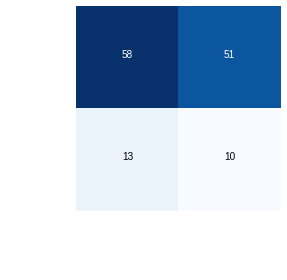

accuracy: 51.515


In [133]:
pca = PCA(n_components=2)

# print("INTERIEUR/EXTERIEUR")
# #notre meilleur préd est de 62% < 64% LOL
# print ("\nconfusion cuts")
# df_1, confusion_1, acc_1, params_1 = KNN_plus_gridsearch(cuts_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_1*100:.3f} %")

# print("\nconfusion_histo")
# df_2, confusion_2, acc_2, params_2 = KNN_plus_gridsearch(histo_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_2*100:.3f} %")

# print("\nconfusion momentum")
# df_3, confusion_3, acc_3, params_3 = KNN_plus_gridsearch(momentum_pca, y_intext.Exterieur[0:308], 7, 50)
# print(f"accuracy: {acc_3*100:.3f} %")


print("VIOLENT/NON-VIOLENT")
print ("\nconfusion cuts")
y_train, y_test, X_train, X_test = split_train_test(df_cuts, y_intext[0:308], "Exterieur")
cuts_pca = pca.fit_transform(X_train)
df_1, confusion_1, acc_1, params_1 = KNN_plus_gridsearch(y_train, y_test, cuts_pca, X_test, 7, 50)
print(f"accuracy: {acc_1*100:.3f}")
# print("\nconfusion_histo")
# y_train, y_test, X_train, X_test = split_train_test(df_histo, y_intext[0:308], "Exterieur")
# histo_pca = pca.fit_transform(X_train)
# df_2, confusion_2, acc_2, params_2 = KNN_plus_gridsearch(y_train, y_test, histo_pca, X_test, 7, 50)
# print(f"accuracy: {acc_2*100:.3f}")

# print("\nconfusion momentum")
# df_3, confusion_3, acc_3, params_3 = KNN_plus_gridsearch(momentum_pca, y_violent.Violent[0:308], 7, 50)
# print(f"accuracy: {acc_3*100:.3f}")


##III. Restitution

In [0]:
def plot_cluster(coords, names, labels, name_plot):
    ''' 
    Create a scatter plot
    
    Arguments:
        coords {numpy array} -- A numpy array with N lines and 2 columns 
                                (N=number of individuals) each column 
                                correspond to a dimension
        names {list} -- list corresponding to the names of the individuals
        labels {type} -- Label of the cluster (an integer like 0 for the first cluster, 1 for the second...)
        name_plot {str} -- name of the html file of the plot
    '''

    # Create a trace
    trace = go.Scatter(
        x = coords[:, 0],
        y = coords[:, 1],
        mode = 'markers',
        text = names,
        marker = dict(
            size = 10,
            color = labels,
            line = dict(
                width = 2,
                color = 'rgb(0, 0, 0)'
            )
        )
    )

    data = [trace]

    layout = dict(title = 'Styled Scatter',
                    yaxis = dict(zeroline = False),
                    xaxis = dict(zeroline = False)
                    )

    fig = dict(data=data, layout=layout)
    plot(fig, filename=name_plot)

In [0]:
# we use the following variables initialized in the lecture cell
# - features
# - annotations
# - annotations_file

all_PCA = [cuts_pca, momentum_pca]
k_sale = 0
for i in (features):
    print("2")
    for j in range(len(annotations)):
        names = (i['Sequence']).tolist()
        labels = pd.Series((0,1))
        if k == 2:
            print("euh")
            plot_cluster(all_PCA[j], names, labels, "gdrive/My Drive/AED/clustering_vidéo.html")

        display(HTML("gdrive/My Drive/AED/test_clustering.html"))
        k +=1
        
# TODO: visualiser tous les graphiques et pas seulement le premier

2
